# Betting markets - Monte Carlo simulation of seat outcomes

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Do-the-Monte-Carlo-(MC)-simulation" data-toc-modified-id="Do-the-Monte-Carlo-(MC)-simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do the Monte Carlo (MC) simulation</a></span></li><li><span><a href="#Compile-results-from-MC-simulation" data-toc-modified-id="Compile-results-from-MC-simulation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compile results from MC simulation</a></span></li><li><span><a href="#And-plot-..." data-toc-modified-id="And-plot-...-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>And plot ...</a></span></li></ul></div>

## Python set-up

In [1]:
import datetime

import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import matplotlib.patheffects as pe

import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER, COLOR_GREEN

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter
plt.style.use('./markgraph.mplstyle')

/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Get data

In [2]:
FILE = '../historical-data/sportsbet-2022-individual-seats.csv'
df = pd.read_csv(FILE, na_values = 'SUS', parse_dates=['datetime'])
df = df[df['value'].notna()] # ignore missing values

## Do the Monte Carlo (MC) simulation 

In [3]:
# Key constants ...
IGNORE_ODDS_ABOVE = 20 # dollars - minimise impact of long shot bias
MONTE_CARLO = 500_000 # simulation runs
WIN_THRESH = 75.5 # seats in parliament needed to govern outright

In [4]:
simulations = {}
for seat in df.seat.unique():
    
    # get latest betting market probabilities 
    seat_probs = (
        df[df.seat == seat]
        .pivot(index='datetime', columns='variable', values='value')
        .sort_index(ascending=True)
        .pipe(lambda x: x.iloc[-1]) # last row
        .pipe(lambda x: x.where(x <= IGNORE_ODDS_ABOVE, other=np.nan))
        .dropna()
        .pipe(lambda x: 1 / x)
        .pipe(lambda x: x / x.sum())
    )
    
    # fix quirky naming by bookmaker
    reindex_map = {
        'Liberal': 'Coalition',
    }
    seat_probs = seat_probs.rename(index=reindex_map)
    
    # simulate election in seat
    simulation = choice(a=seat_probs.index, size=MONTE_CARLO, 
                        p=seat_probs.values)
    simulations[seat] = simulation
results = pd.DataFrame(simulations).T
results.head()

,0,1,2,3,4,5,6,7,8,9,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
Banks (NSW),Labor,Labor,Labor,Coalition,Labor,Coalition,Coalition,Coalition,Coalition,Coalition,...,Coalition,Coalition,Coalition,Coalition,Labor,Labor,Labor,Coalition,Coalition,Coalition
Barton (NSW),Labor,Labor,Labor,Coalition,Labor,Labor,Labor,Labor,Coalition,Labor,...,Labor,Labor,Labor,Labor,Labor,Labor,Coalition,Labor,Coalition,Labor
Bennelong (NSW),Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Labor,...,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Labor,Coalition,Coalition
Berowra (NSW),Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Labor,Coalition,Coalition,Coalition,...,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition,Coalition
Blaxland (NSW),Labor,Labor,Labor,Labor,Labor,Labor,Coalition,Labor,Labor,Labor,...,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor,Labor


## Compile results from MC simulation

In [5]:
# count the seats won by party for each simulation run
# this step takes around 25 seconds if MC=100,000 and 2 minutes if MC=500,000
counts = {}
for run in results.columns:
    counts[run] = results[run].value_counts()
counts_df = pd.DataFrame(counts).T
counts_df.head()

,Centre Alliance,Coalition,Green,Independent,Jacqui Lambie Network,Katters Australia Party,Labor,United Australia Party
0,NaN,69.0,3.0,4.0,NaN,NaN,75.0,NaN
1,1.0,73.0,2.0,3.0,NaN,1.0,71.0,NaN
2,1.0,70.0,4.0,3.0,NaN,1.0,72.0,NaN
3,1.0,70.0,1.0,4.0,NaN,1.0,74.0,NaN
4,NaN,68.0,4.0,4.0,NaN,1.0,74.0,NaN


In [6]:
# Simplified columns
majors = ['Coalition', 'Labor', 'Green']
simplified = counts_df[majors].copy()
simplified['Other'] = (
    counts_df[[x for x in counts_df.columns if x not in majors]]
    .sum(axis=1, skipna=True)
)
simplified.head()

,Coalition,Labor,Green,Other
0,69.0,75.0,3.0,4.0
1,73.0,71.0,2.0,5.0
2,70.0,72.0,4.0,5.0
3,70.0,74.0,1.0,6.0
4,68.0,74.0,4.0,5.0


In [7]:
# hung parliament probability
coalition = ((simplified['Coalition'] > WIN_THRESH).sum() / MONTE_CARLO) * 100 # %
labor = ((simplified['Labor'] > WIN_THRESH).sum() / MONTE_CARLO) * 100 # %
hung = 100 - coalition - labor
parliament = pd.Series([coalition, hung, labor], 
                       index=['Absolute Coalition Majority', 
                              'Hung Parliament', 
                              'Absolute Labor Majority'])
parliament

Absolute Coalition Majority     3.3338
Hung Parliament                58.7348
Absolute Labor Majority        37.9314
dtype: float64

In [8]:
# Count the distribution of seats won by party group, convert to probabilities
freq = {}
for party in simplified.columns:
    freq[party] = simplified[party].value_counts(dropna=True)
win_prob = (pd.DataFrame(freq).fillna(0) / MONTE_CARLO) * 100

In [9]:
# include probability of winning no seats
zero_seats = 100 - win_prob.sum()
win_prob.loc[0] = zero_seats
win_prob.head()

,Coalition,Labor,Green,Other
0.0,0.0,0.0,1.1812,1.421085e-14
1.0,0.0,0.0,18.6020,3.720000e-02
2.0,0.0,0.0,32.5238,4.226000e-01
3.0,0.0,0.0,27.3664,2.458600e+00
4.0,0.0,0.0,13.9492,8.214600e+00


## And plot ...

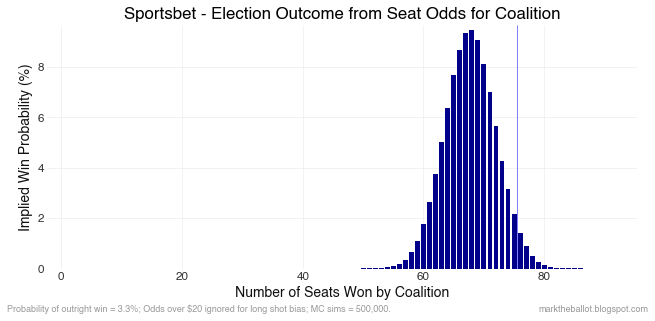

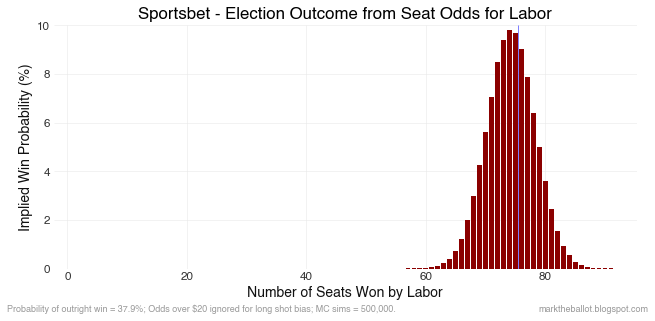

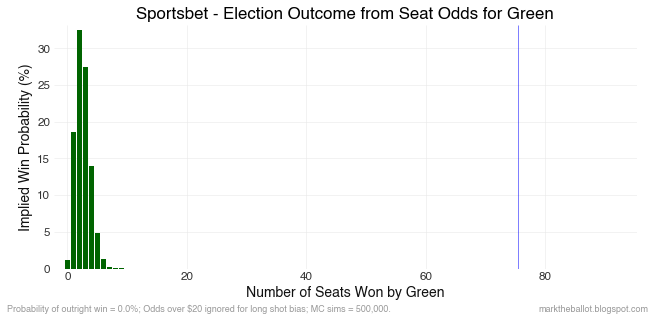

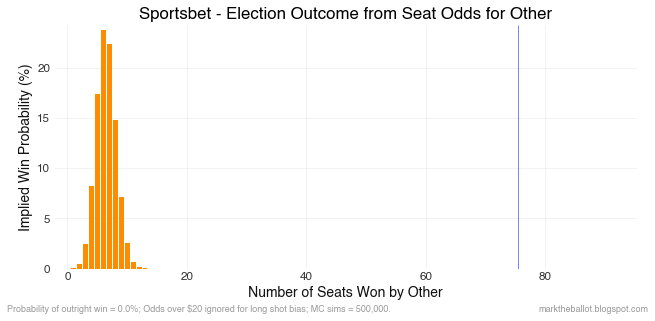

In [10]:
# Plot outcome distributions by party
color_map = {
    'Coalition': COLOR_COALITION, 
    'Labor': COLOR_LABOR, 
    'Other': COLOR_OTHER, 
    'Green': COLOR_GREEN   
}

for party in win_prob.columns:
    data = win_prob[party]
    fig, ax = common.initiate_plot()
    ax.bar(data.index, data, color=color_map[party])
    ax.axvline(WIN_THRESH, lw=0.5, c='b')
    title = f'Sportsbet - Election Outcome from Seat Odds for {party}'
    outright = data[data.index > WIN_THRESH].sum()
    lfooter = (
        f'Probability of outright win = {outright:.1f}%; '
        f'Odds over ${IGNORE_ODDS_ABOVE} ignored for long shot bias; '
        f'MC sims = {MONTE_CARLO:,}.'
    )
    common.plot_finalise(ax, title=title, ylabel='Implied Win Probability (%)',
                         xlabel=f'Number of Seats Won by {party}',
                         lfooter=lfooter)

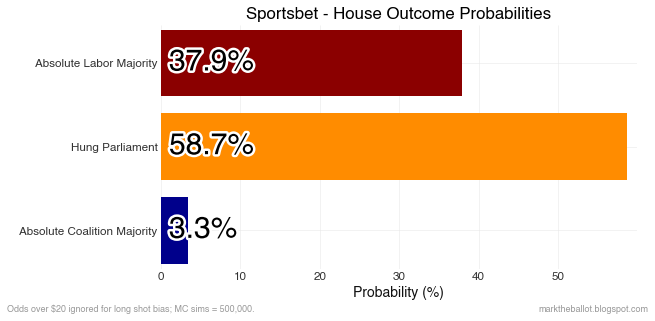

In [11]:
# Plot House Outcome Probabilities
fig, ax = common.initiate_plot()
colors = [COLOR_COALITION, COLOR_OTHER, COLOR_LABOR, ]
ax.barh(parliament.index, parliament, color=colors)
for index, value in parliament.iteritems():
    text = ax.text(x=1, y=index, s=f'{value:.1f}%', 
                   fontsize=30, ha='left', va='center')
    text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])

lfooter = (
    f'Odds over ${IGNORE_ODDS_ABOVE} ignored for long shot bias; '
    f'MC sims = {MONTE_CARLO:,}.'
)
common.plot_finalise(ax, 'Sportsbet - House Outcome Probabilities',
                     ylabel=None,
                     xlabel='Probability (%)',
                     lfooter=lfooter, 
                   )